In [1]:
import torch
import torch.nn as nn
import torch.optim as optim
from torchvision import datasets, transforms, models
from torch.utils.data import DataLoader
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
from sklearn.metrics import confusion_matrix
import seaborn as sns
import os
import time

# Use GPU if available
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print(f"Using device: {device}")

torch.cuda.empty_cache()

os.makedirs('results', exist_ok=True)

Using device: cuda


# Cargar datos

In [2]:
transform = transforms.Compose([
    transforms.Grayscale(3),
    transforms.Resize(224),
    transforms.ToTensor(),
    transforms.Normalize(mean=[0.485, 0.456, 0.406],
                        std=[0.229, 0.224, 0.225])
])

mnist_train = datasets.MNIST(root='./data', train=True, download=True, transform=transform)
mnist_test = datasets.MNIST(root='./data', train=False, download=True, transform=transform)

train_loader = DataLoader(mnist_train, batch_size=128, shuffle=True, num_workers=4, pin_memory=True, prefetch_factor=4)
test_loader = DataLoader(mnist_test, batch_size=128, shuffle=False, num_workers=4, pin_memory=True, prefetch_factor=4)

print(f"Train samples: {len(mnist_train)}")
print(f"Test samples: {len(mnist_test)}")

Train samples: 60000
Test samples: 10000


# Definición de modelos

In [3]:
model = models.mobilenet_v2(pretrained=True)

# Freeze all pre-trained layers
for param in model.parameters():
    param.requires_grad = False

model.classifier[1] = nn.Linear(model.classifier[1].in_features, 10)

model = model.to(device)

print(f"Total parameters: {sum(p.numel() for p in model.parameters()):,}")
print(f"VRAM: {torch.cuda.memory_allocated() / 1e9:.2f}GB")

/home/zeus/miniconda3/envs/cloudspace/lib/python3.12/site-packages/torchvision/models/_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.
  warnings.warn(
/home/zeus/miniconda3/envs/cloudspace/lib/python3.12/site-packages/torchvision/models/_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=MobileNet_V2_Weights.IMAGENET1K_V1`. You can also use `weights=MobileNet_V2_Weights.DEFAULT` to get the most up-to-date weights.
  warnings.warn(msg)


Total parameters: 2,236,682
VRAM: 0.01GB


# Funciones de evaluación

In [4]:


def evaluate_on_test_set(model, test_loader, criterion, device):
    model.eval()

    test_loss = 0
    correct = 0
    total = 0

    all_preds = []
    all_labels = []

    with torch.no_grad():
        for images, labels in test_loader:
            images = images.to(device, non_blocking=True)
            labels = labels.to(device, non_blocking=True)

            # Forward pass
            outputs = model(images)
            loss = criterion(outputs, labels)

            # Calcular accuracy
            _, predicted = torch.max(outputs.data, 1)
            total += labels.size(0)
            correct += (predicted == labels).sum().item()

            # Guardar predicciones
            all_preds.extend(predicted.cpu().numpy())
            all_labels.extend(labels.cpu().numpy())

            test_loss += loss.item()

    avg_test_loss = test_loss / len(test_loader)
    test_accuracy = 100 * correct / total

    return {
        'loss': avg_test_loss,
        'accuracy': test_accuracy,
        'predictions': np.array(all_preds),
        'labels': np.array(all_labels)
    }


def evaluate_model(model, test_loader, criterion, device, epoch):
    print(f"\n{'='*60}")
    print(f"📊 Evaluating at Epoch {epoch+1}")
    print(f"{'='*60}")

    test_metrics = evaluate_on_test_set(model, test_loader, criterion, device)
    test_metrics['epoch'] = epoch

    print(f"\n📈 Test Set Evaluation:")
    print(f"  • Loss: {test_metrics['loss']:.4f}")
    print(f"  • Accuracy: {test_metrics['accuracy']:.2f}%")
    print(f"{'='*60}\n")

    return test_metrics

# Funciones de training

In [5]:


def train_epoch(model, train_loader, criterion, optimizer, device):
    model.train()

    epoch_loss = 0
    correct = 0
    total = 0

    for images, labels in train_loader:
        images = images.to(device, non_blocking=True)
        labels = labels.to(device, non_blocking=True)

        # Forward pass
        optimizer.zero_grad()
        outputs = model(images)
        loss = criterion(outputs, labels)

        # Backward pass
        loss.backward()
        optimizer.step()

        # Estadísticas
        epoch_loss += loss.item()
        _, predicted = torch.max(outputs.data, 1)
        total += labels.size(0)
        correct += (predicted == labels).sum().item()

    avg_loss = epoch_loss / len(train_loader)
    accuracy = 100 * correct / total

    return avg_loss, accuracy

# Training loop

In [6]:
print("\n" + "="*60)
print("🚀 STARTING TRAINING")
print("="*60)

# Hiperparámetros
lr = 0.001
num_epochs = 10

criterion = nn.CrossEntropyLoss()
optimizer = optim.Adam(model.parameters(), lr=lr)

# Almacenar métricas
train_losses = []
train_accs = []
test_results = []

for epoch in range(num_epochs):
    start_time = time.time()
    train_loss, train_acc = train_epoch(model, train_loader, criterion, optimizer, device)
    train_losses.append(train_loss)
    train_accs.append(train_acc)
    end_time = time.time()
    print(f"Epoch {epoch+1}/{num_epochs} - "
          f"Train Loss: {train_loss:.4f}, Train Acc: {train_acc:.2f}%,"
          f" Time: {end_time - start_time:.2f}s")

    if (epoch + 1) % 5 == 0 or epoch == num_epochs - 1 or epoch == 0:
        test_metrics = evaluate_model(model, test_loader, criterion, device, epoch)
        test_results.append(test_metrics)

print("\n" + "="*60)
print("✅ TRAINING COMPLETED")
print("="*60)

torch.save(model.state_dict(), 'results/model.pth')
print("💾 Model saved to: results/model.pth")


🚀 STARTING TRAINING
Epoch 1/10 - Train Loss: 0.4334, Train Acc: 88.71%, Time: 72.35s

📊 Evaluating at Epoch 1

📈 Test Set Evaluation:
  • Loss: 0.2045
  • Accuracy: 94.33%

Epoch 2/10 - Train Loss: 0.2126, Train Acc: 93.60%, Time: 70.08s
Epoch 3/10 - Train Loss: 0.1812, Train Acc: 94.46%, Time: 70.31s
Epoch 4/10 - Train Loss: 0.1669, Train Acc: 94.76%, Time: 70.18s
Epoch 5/10 - Train Loss: 0.1612, Train Acc: 94.89%, Time: 69.93s

📊 Evaluating at Epoch 5

📈 Test Set Evaluation:
  • Loss: 0.1231
  • Accuracy: 96.07%

Epoch 6/10 - Train Loss: 0.1541, Train Acc: 95.03%, Time: 71.08s
Epoch 7/10 - Train Loss: 0.1477, Train Acc: 95.26%, Time: 66.97s
Epoch 8/10 - Train Loss: 0.1460, Train Acc: 95.21%, Time: 72.64s
Epoch 9/10 - Train Loss: 0.1429, Train Acc: 95.33%, Time: 73.49s
Epoch 10/10 - Train Loss: 0.1409, Train Acc: 95.46%, Time: 73.41s

📊 Evaluating at Epoch 10

📈 Test Set Evaluation:
  • Loss: 0.1054
  • Accuracy: 96.61%


✅ TRAINING COMPLETED
💾 Model saved to: results/model.pth


# Guardar métricas

In [7]:

training_metrics = {
    'epoch': list(range(1, num_epochs + 1)),
    'loss': train_losses,
    'accuracy': train_accs
}
df_training = pd.DataFrame(training_metrics)
df_training.to_csv('results/training_metrics.csv', index=False)
print("💾 Training metrics saved to: results/training_metrics.csv")

test_metrics_dict = {
    'epoch': [r['epoch'] + 1 for r in test_results],
    'loss': [r['loss'] for r in test_results],
    'accuracy': [r['accuracy'] for r in test_results]
}
df_test = pd.DataFrame(test_metrics_dict)
df_test.to_csv('results/test_metrics.csv', index=False)
print("💾 Test metrics saved to: results/test_metrics.csv")

💾 Training metrics saved to: results/training_metrics.csv
💾 Test metrics saved to: results/test_metrics.csv


# Visualizaciones

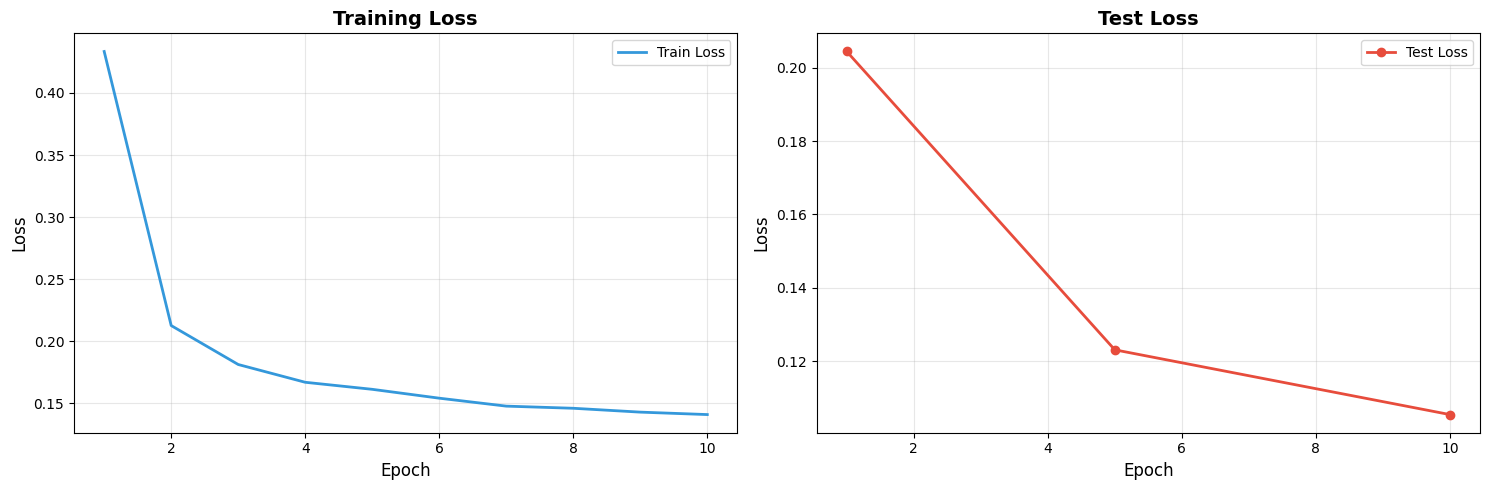

In [8]:
fig, axes = plt.subplots(1, 2, figsize=(15, 5))

# Training Loss
axes[0].plot(range(1, num_epochs + 1), train_losses,
             label='Train Loss', linewidth=2, color='#3498db')
axes[0].set_xlabel('Epoch', fontsize=12)
axes[0].set_ylabel('Loss', fontsize=12)
axes[0].set_title('Training Loss', fontsize=14, fontweight='bold')
axes[0].legend()
axes[0].grid(True, alpha=0.3)

# Test Loss
test_epochs = [r['epoch'] + 1 for r in test_results]
test_losses = [r['loss'] for r in test_results]
axes[1].plot(test_epochs, test_losses,
             label='Test Loss', linewidth=2, marker='o', color='#e74c3c')
axes[1].set_xlabel('Epoch', fontsize=12)
axes[1].set_ylabel('Loss', fontsize=12)
axes[1].set_title('Test Loss', fontsize=14, fontweight='bold')
axes[1].legend()
axes[1].grid(True, alpha=0.3)

plt.tight_layout()
plt.savefig('results/losses_comparison.png', dpi=150, bbox_inches='tight')
plt.show()

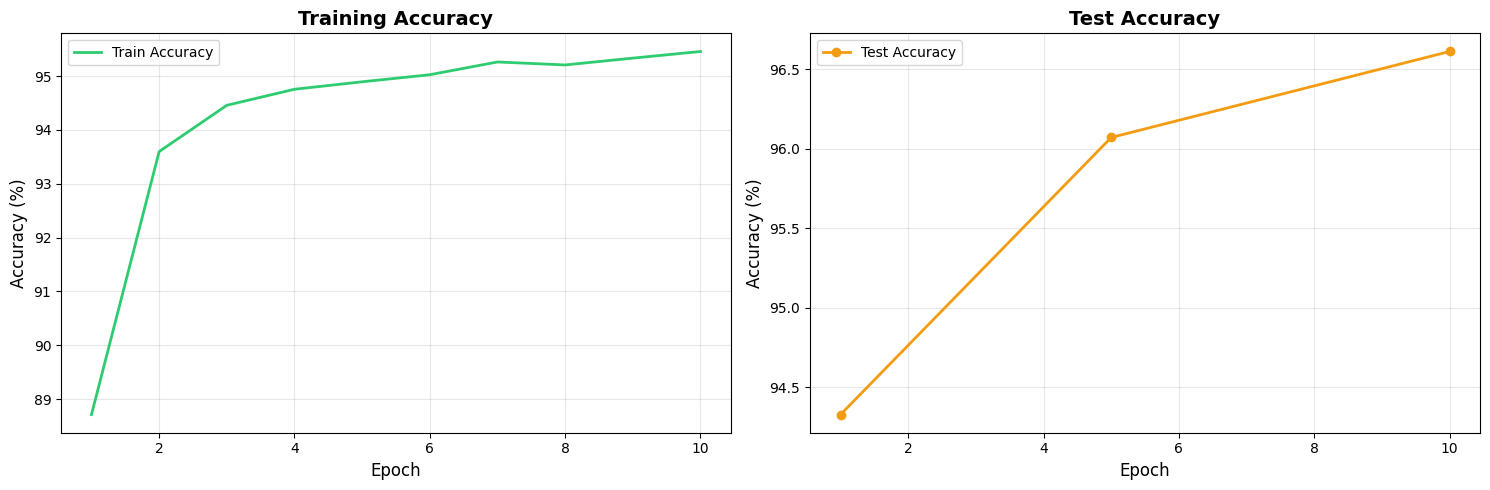

In [9]:
fig, axes = plt.subplots(1, 2, figsize=(15, 5))

# Training Accuracy
axes[0].plot(range(1, num_epochs + 1), train_accs,
             label='Train Accuracy', linewidth=2, color='#2ecc71')
axes[0].set_xlabel('Epoch', fontsize=12)
axes[0].set_ylabel('Accuracy (%)', fontsize=12)
axes[0].set_title('Training Accuracy', fontsize=14, fontweight='bold')
axes[0].legend()
axes[0].grid(True, alpha=0.3)

# Test Accuracy
test_accs = [r['accuracy'] for r in test_results]
axes[1].plot(test_epochs, test_accs,
             label='Test Accuracy', linewidth=2, marker='o', color='#f39c12')
axes[1].set_xlabel('Epoch', fontsize=12)
axes[1].set_ylabel('Accuracy (%)', fontsize=12)
axes[1].set_title('Test Accuracy', fontsize=14, fontweight='bold')
axes[1].legend()
axes[1].grid(True, alpha=0.3)

plt.tight_layout()
plt.savefig('results/accuracy_comparison.png', dpi=150, bbox_inches='tight')
plt.show()

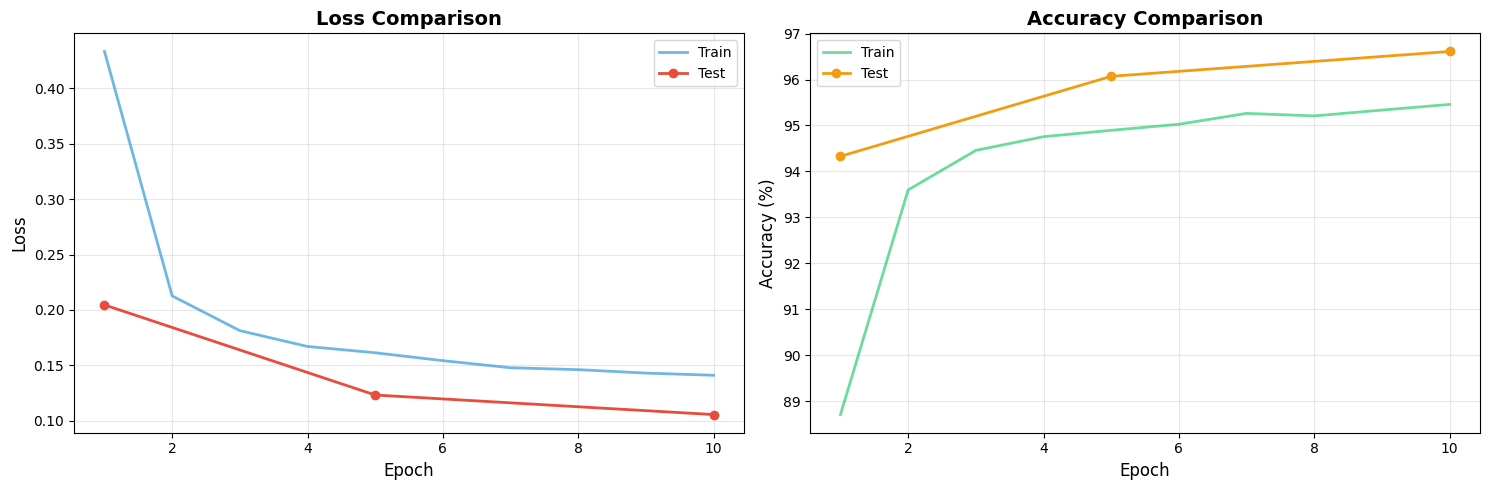

In [10]:
fig, axes = plt.subplots(1, 2, figsize=(15, 5))

# Loss
axes[0].plot(range(1, num_epochs + 1), train_losses,
             label='Train', linewidth=2, alpha=0.7, color='#3498db')
axes[0].plot(test_epochs, test_losses,
             label='Test', linewidth=2, marker='o', color='#e74c3c')
axes[0].set_xlabel('Epoch', fontsize=12)
axes[0].set_ylabel('Loss', fontsize=12)
axes[0].set_title('Loss Comparison', fontsize=14, fontweight='bold')
axes[0].legend()
axes[0].grid(True, alpha=0.3)

# Accuracy
axes[1].plot(range(1, num_epochs + 1), train_accs,
             label='Train', linewidth=2, alpha=0.7, color='#2ecc71')
axes[1].plot(test_epochs, test_accs,
             label='Test', linewidth=2, marker='o', color='#f39c12')
axes[1].set_xlabel('Epoch', fontsize=12)
axes[1].set_ylabel('Accuracy (%)', fontsize=12)
axes[1].set_title('Accuracy Comparison', fontsize=14, fontweight='bold')
axes[1].legend()
axes[1].grid(True, alpha=0.3)

plt.tight_layout()
plt.savefig('results/train_vs_test.png', dpi=150, bbox_inches='tight')
plt.show()

# Evaluación final y matriz de confusión


📊 FINAL EVALUATION

Final Test Accuracy: 96.61%
Final Test Loss: 0.1054


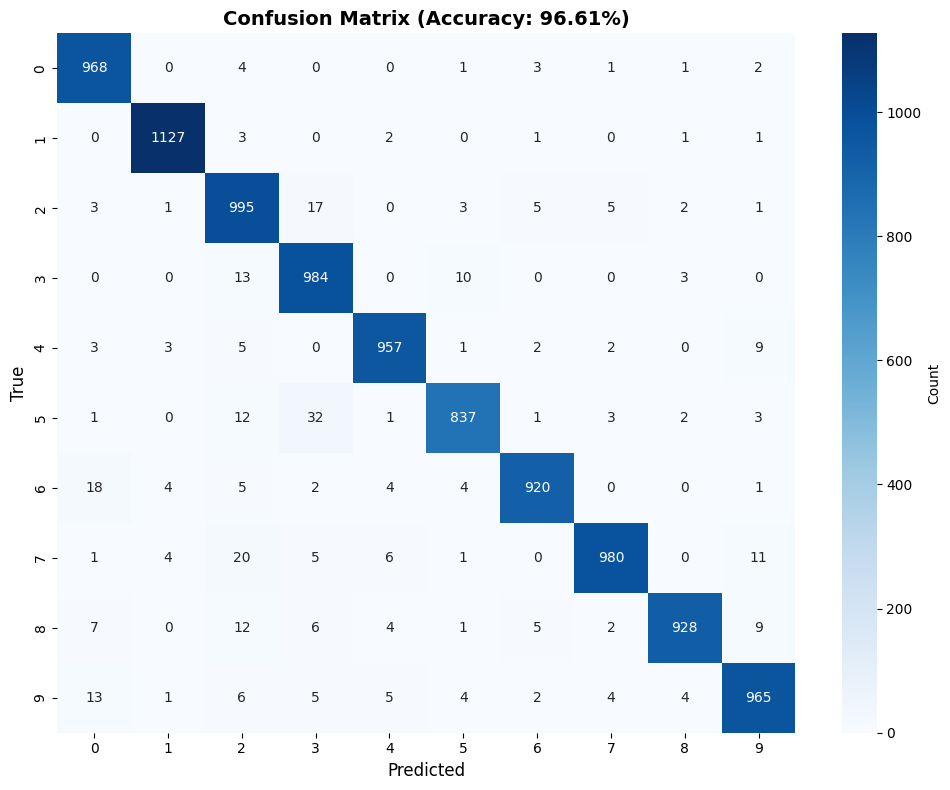

In [11]:
print("\n" + "="*60)
print("📊 FINAL EVALUATION")
print("="*60)

final_results = evaluate_on_test_set(model, test_loader, criterion, device)

print(f"\nFinal Test Accuracy: {final_results['accuracy']:.2f}%")
print(f"Final Test Loss: {final_results['loss']:.4f}")

# Matriz de confusión
cm = confusion_matrix(final_results['labels'], final_results['predictions'])

plt.figure(figsize=(10, 8))
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', cbar_kws={'label': 'Count'})
plt.xlabel('Predicted', fontsize=12)
plt.ylabel('True', fontsize=12)
plt.title(f'Confusion Matrix (Accuracy: {final_results["accuracy"]:.2f}%)',
          fontsize=14, fontweight='bold')
plt.tight_layout()
plt.savefig('results/confusion_matrix.png', dpi=150, bbox_inches='tight')
plt.show()